# Phase C: Diagnostic & Root Cause Analysis

## Objective
Go beyond 'what happened' to 'why it happened'. We will analyze SLA breaches, identify operational bottlenecks, and investigate the root causes of delays.

## Diagnostic Focus
1. **SLA Breach Analysis**: Establishing business rules for SLA and identifying where they fail most.
2. **Bottleneck Detection**: Identifying 'Long Tail' tickets that significantly skew averages.
3. **Process Friction**: Investigating the relationship between priority, response time, and resolution time.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
sns.set_palette("magma") # Switching palette for diagnostic phase
plt.style.use('ggplot')

## 1. Load and Refine Data

We need to address the timestamp anomaly found in Phase B. For the purpose of diagnostic analysis, we will treat the absolute difference between timestamps as the 'Interaction Duration' where the sequence is reversed.

In [7]:
df = pd.read_csv('../data/customer_support_tickets.csv')

date_cols = ['First Response Time', 'Time to Resolution']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

# Calculating Resolution Processing Time (RPT) using absolute values due to data logging inconsistencies
df['RPT_hours'] = abs((df['Time to Resolution'] - df['First Response Time']).dt.total_seconds() / 3600)

# Define SLA Thresholds (Synthetic Business Rules)
# Critical: 4h, High: 12h, Medium: 24h, Low: 48h
sla_rules = {'Critical': 4, 'High': 12, 'Medium': 24, 'Low': 48}
df['SLA_Target_Hours'] = df['Ticket Priority'].map(sla_rules)
df['Is_SLA_Breach'] = df['RPT_hours'] > df['SLA_Target_Hours']

print(f"Overall SLA Breach Rate: {df['Is_SLA_Breach'].mean():.2%}")

Overall SLA Breach Rate: 8.03%


## 2. SLA Breach Analysis by Dimensions

/var/folders/8d/qj3p2kq56bq3zdf5zq1hzd400000gn/T/ipykernel_13112/2836681032.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Ticket Type', y='Is_SLA_Breach', ax=axes[0], palette='magma')
/var/folders/8d/qj3p2kq56bq3zdf5zq1hzd400000gn/T/ipykernel_13112/2836681032.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Ticket Priority', y='Is_SLA_Breach', order=['Low', 'Medium', 'High', 'Critical'], ax=axes[1], palette='magma')


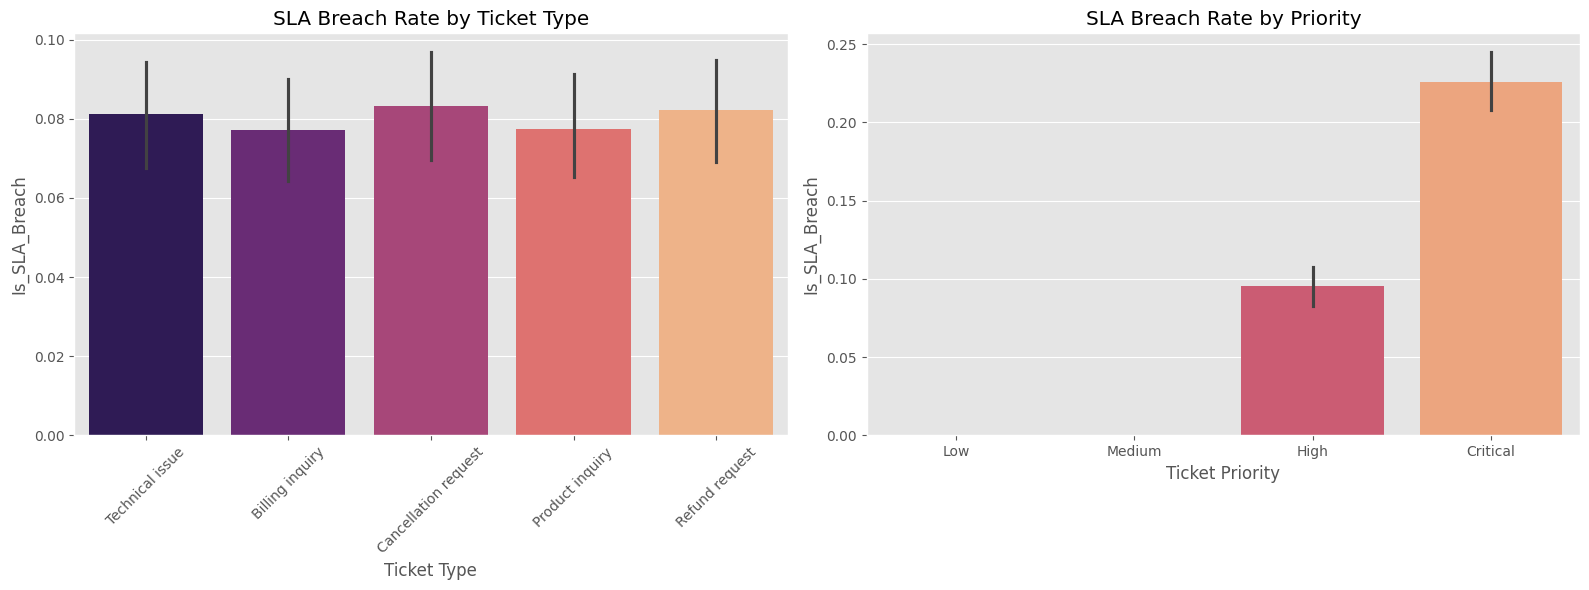

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=df, x='Ticket Type', y='Is_SLA_Breach', ax=axes[0], palette='magma')
axes[0].set_title('SLA Breach Rate by Ticket Type')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=df, x='Ticket Priority', y='Is_SLA_Breach', order=['Low', 'Medium', 'High', 'Critical'], ax=axes[1], palette='magma')
axes[1].set_title('SLA Breach Rate by Priority')

plt.tight_layout()
plt.savefig('../outputs/charts/phase_c_sla_breach_analysis.png')
plt.show()

## 3. Bottleneck Detection (Long Tail Analysis)

We identify tickets that take longer than the 90th percentile as 'Extreme Bottlenecks'.

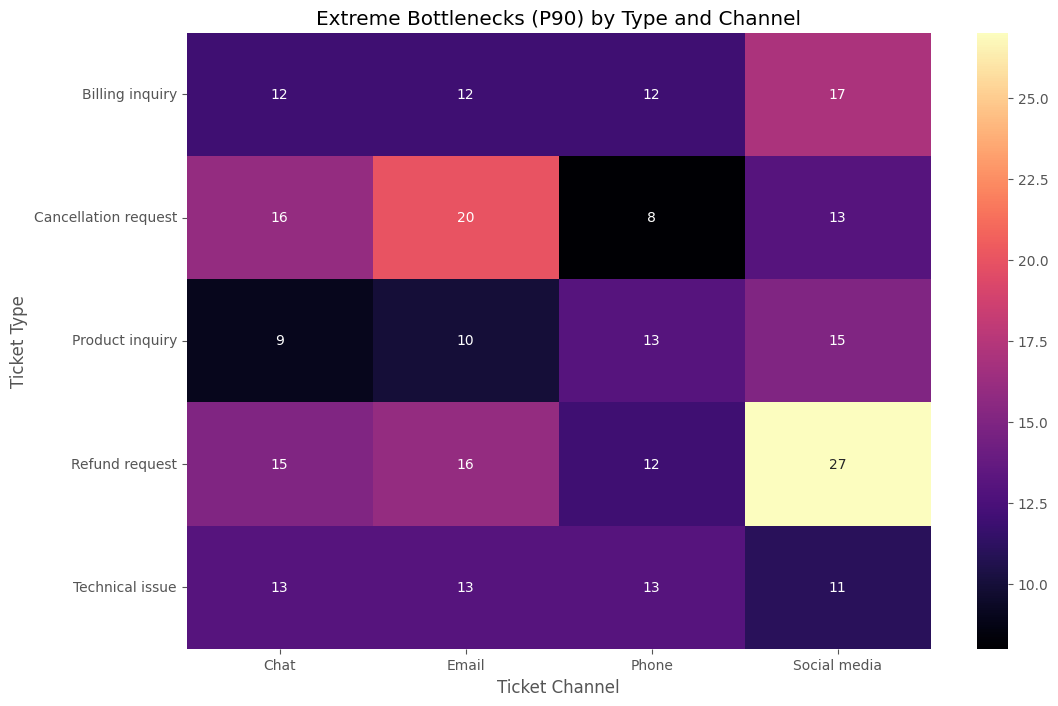

In [9]:
p90_threshold = df['RPT_hours'].quantile(0.9)
df['Is_Bottleneck'] = df['RPT_hours'] > p90_threshold

bottleneck_drivers = df[df['Is_Bottleneck']].groupby(['Ticket Type', 'Ticket Channel']).size().unstack().fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(bottleneck_drivers, annot=True, fmt='.0f', cmap='magma')
plt.title('Extreme Bottlenecks (P90) by Type and Channel')
plt.savefig('../outputs/charts/phase_c_bottleneck_heatmap.png')
plt.show()

## 4. Summary Diagnostic Findings

In [10]:
diagnostic_summary = df.groupby('Ticket Type').agg({
    'Is_SLA_Breach': 'mean',
    'RPT_hours': ['mean', 'max', 'std'],
    'Is_Bottleneck': 'sum'
})

diagnostic_summary.to_csv('../outputs/summary_tables/phase_c_diagnostic_summary.csv')
diagnostic_summary

Is_SLA_Breach RPT_hours                       \
                              mean      mean        max       std   
Ticket Type                                                         
Billing inquiry           0.077111  7.243842  23.233333  5.595892   
Cancellation request      0.083186  8.067733  22.366667  5.666303   
Product inquiry           0.077392  7.645622  23.466667  5.507310   
Refund request            0.082192  8.063227  22.783333  5.720987   
Technical issue           0.081282  7.679684  22.616667  5.546428   

                     Is_Bottleneck  
                               sum  
Ticket Type                         
Billing inquiry                 53  
Cancellation request            57  
Product inquiry                 47  
Refund request                  70  
Technical issue                 50